# Indel/gap metric example

To get started with sequences, we begin by importing some useful python packages:

In [1]:
# useful imports
import sys, re # re is regular expression lib
import numpy as np
import pandas as pd
from Bio import AlignIO, SeqIO, Seq 
import matplotlib.pyplot as plt
import seaborn as sns

Read input MSA conatins gaps representing indel events:

In [9]:
align = AlignIO.read('./samples/arpip/msa.fasta', 'fasta')

Extract gap length for each strach of gap per each record and store them in a dictionary: 

In [10]:
# making an empty dictionary of species to store the information
dict_gap_len_species = {}
for rec in align:
    dict_gap_len_species[rec.id] = []
# print(dict_gap_len_species)

# gap length per each specie
for record in align:
    tmp_rc_id = ''
    matches = list(re.finditer('-+', str(record.seq)))
    # when a stretch of gap exists
    if len(matches) != 0:
        if tmp_rc_id != record.id:
            tmp_rc_id = record.id
        for region_number, match in enumerate(matches, 1):
            # store the gap length
            gap_length = match.end() - match.start()
            dict_gap_len_species[record.id].append(gap_length)

Plot the gap length distribution

The list of gap elements: [4, 4, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 3, 1, 1]


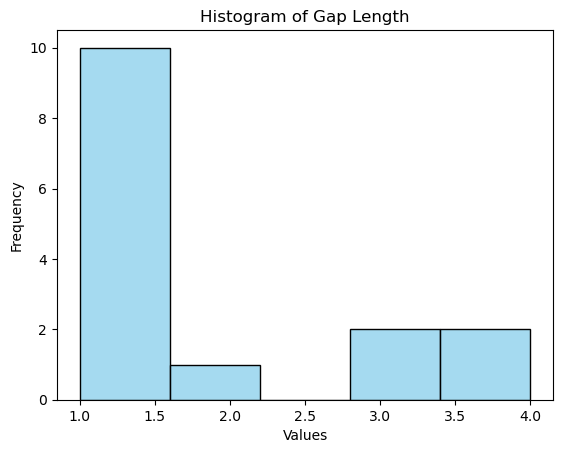

In [15]:
lst_gap_lengths = sum(dict_gap_len_species.values(), [])
print("The list of gap elements:", (lst_gap_lengths))

# Plot histogram
sns.histplot(lst_gap_lengths, bins=5, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Gap Length')

# Show the plot
plt.show()

### Extracting indel events

Defining some functions to extract indel points for gappy sites

In [33]:
def extract_gappy_cols(msa):
    """
    :param msa: alignment file in AlionIO format (see BioPython for more)
    return: list of column numbers containing gap charcter
    """
    gappy_col = []
    # row counter
    r_counter = 0
    for record in msa:
        # col counter
        c_counter = 0
        for i in record:
            if i == '-':
                gappy_col.append(c_counter)
            c_counter += 1
        r_counter += 1
    return list(set(gappy_col))
  


def get_indel_events(event_file_address, list_names, lst_gappy_col_numbs=0):
    """
    param: events: event file in text fomat
    param: list_names: name of all nodes
    param: list_gappy_col_numbs: list of gappy column in the alignment file
    return: puting the event in 3 files: mat_in/del matrix of events seperately
    mat_insrtion/deletion of size(m*n) and events of size(2*m)
    """

    # Read the events file
    try:
        # Read the events file
        f = open(event_file_address, 'r')
        events = f.readlines()
        
        # Compute the sequence length
        seq_len = len(events)
        if seq_len == 0:
            print("The input file is empty")

        dic_event = {}
        mat_insertion = np.zeros([seq_len, len(list_names)])
        mat_insertion
        mat_deletion = np.zeros([seq_len, len(list_names)])
        mat_deletion
        dic_name_index = {}
        counter = 0

        # Making a dictionary of name and index of tree's nodes
        for element in list_names:
            dic_name_index[element] = counter
            counter += 1
        
        # Check  to see if there is a column with gap in the alignment file
        if lst_gappy_col_numbs:
            for i, line in enumerate(events):
                if i in lst_gappy_col_numbs:
                    try:
                        if line.strip():
                            dic_event[i + 1] = line.strip()
                            s = line.split(';')
                            for sub in s:
                                if ':X' in sub:
                                    strd = sub.split(':X')
                                    for sub_str_id in strd[:-1]:
                                        mat_deletion[i, dic_name_index[sub_str_id]] = 1
                                elif ':I' in sub:
                                    stri = sub.split(':I')
                                    for sub_str_id in stri[:-1]:
                                        mat_insertion[i, dic_name_index[sub_str_id]] = 1
                    except KeyError:
                        if not (sub_str_id in list_names):
                            print("Error: Node with name [%s]  could not be found in the tree." % sub_str_id)
                        else:
                            print("ERROR")

        df_event = pd.Series(dic_event)
        f.close()
        return df_event, mat_insertion, mat_deletion, dic_name_index
    except KeyError:
        print("Error: We cannot read the input file")


### Computing the indel bias

In [34]:
# Read the fasta file
aln = AlignIO.read('./samples/arpip/anc.fasta', 'fasta')

# The list of all nodes
lst_node_names = [str(rec.id) for rec in aln]
print("The list of node's name:\n", lst_node_names)
print("\n")

# Extract gappy columns
lst_gap_col_numbs = extract_gappy_cols(aln)
print("The list of alignment columns contining gap:\n", lst_gap_col_numbs)

if lst_gap_cols:
    # Parse the indel events file
    path_to_indel_events = './samples/arpip/mlindelpoints.txt'
    df_event, mat_ins, mat_del, dic_name_index = get_indel_events(path_to_indel_events, lst_node_names, lst_gap_col_numbs)
    
    num_ins = int(mat_ins.sum())
    num_del = int(mat_del.sum())
    print("\n")
    print("Total number of insertion is %s and deletion is %s" %(num_ins, num_del))
    
    num_ins_pr_spc = np.sum(mat_ins, axis=0)
    num_del_pr_spc = np.sum(mat_del, axis=0)
    print("\nTotal number of insertion per spc:\n", num_ins_pr_spc)
    print("Total number of deletion per spc:\n", num_del_pr_spc)
    print("\n")
    
    # Compute the indel ratio as the number of deletions devided by number of insertions
    indel_ratio = num_del/num_ins
    print("The indel ratio is: %s" %(indel_ratio))
    
    # Compute the indel bias as the number of insertions devided by number of deletions
    indel_bias = num_ins/num_del
    print("The indel bias over all the lineages: %s" %indel_bias)
    print("\n")
    
    # Compute the indel bias per lineage
    indel_bias_pr_spc = num_ins_pr_spc[0]/num_del_pr_spc[0]
    print("The indel bias per %s lineages: %s" %(lst_node_names[0],indel_bias_pr_spc))
    


The list of node's name:
 ['leaf_0', 'leaf_1', 'leaf_2', 'leaf_3', 'leaf_4', 'leaf_5', 'leaf_6', 'leaf_7', 'V2', 'V5', 'V7', 'V8', 'V12', 'V13', 'root']


The list of alignment columns contining gap:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 22, 24]


Total number of insertion is 17 and deletion is 36

Total number of insertion per spc:
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. 15.]
Total number of deletion per spc:
 [4. 4. 3. 8. 7. 6. 0. 1. 2. 1. 0. 0. 0. 0. 0.]


The indel ratio is: 2.1176470588235294
The indel bias over all the lineages: 0.4722222222222222


The indel bias per leaf_0 lineages: 0.25


Indel bias per node means that the sequences on the lineage are shrinking (less than one) or growing (greater than one).